In [1]:
from torch_geometric.datasets import BA2MotifDataset

dataset = BA2MotifDataset(root='data/BA2Motif')

In [2]:
import ot
import networkx as nx
from torch_geometric.utils import to_dense_adj, to_scipy_sparse_matrix, coalesce
import numpy as np
import torch
from torch_geometric.data import Data
import random

def filter_undirected_edges(edge_index):
    edge_set = set()
    unique_edges = []
    
    for i in range(edge_index.size(1)):
        u, v = sorted(edge_index[:, i].tolist()) 
        edge = (u, v)
        if edge not in edge_set:
            edge_set.add(edge)
            unique_edges.append([u, v])
    
    return torch.tensor(unique_edges, dtype=torch.long).T 

def ensure_undirected(edge_index):
    edge_set = set()
    unique_edges = []
    
    for i in range(edge_index.shape[1]):
        u, v = edge_index[:, i].tolist()
        edge = tuple(sorted((u, v)))
        
        if edge not in edge_set:
            edge_set.add(edge)
            unique_edges.append([u, v])

    bidirectional_edges = []
    for u, v in unique_edges:
        bidirectional_edges.append([u, v])
        bidirectional_edges.append([v, u])
    
    return torch.tensor(bidirectional_edges, dtype=torch.long).T

def pyg_to_fgw_format(graph):
    graph.edge_index = ensure_undirected(graph.edge_index)
    adj = to_dense_adj(graph.edge_index)[0].numpy()
    features = graph.x.numpy()
    p = np.ones(graph.num_nodes) / graph.num_nodes
    
    return adj, features, p

def compute_fgw_distance(graph1, graph2, alpha=0.5):
    # clone graphs
    graph1 = graph1.clone()
    graph2 = graph2.clone()
    C1, features1, p = pyg_to_fgw_format(graph1)
    C2, features2, q = pyg_to_fgw_format(graph2)
    max_nodes = max(features1.shape[0], features2.shape[0])

    # Padding f
    features1 = np.pad(features1, ((0, max_nodes - features1.shape[0]), (0, 0)), mode='constant')
    features2 = np.pad(features2, ((0, max_nodes - features2.shape[0]), (0, 0)), mode='constant')

    C1 = np.pad(C1, ((0, max_nodes - C1.shape[0]), (0, max_nodes - C1.shape[1])), mode='constant')
    C2 = np.pad(C2, ((0, max_nodes - C2.shape[0]), (0, max_nodes - C2.shape[1])), mode='constant')
    
    features1 = features1 / (np.linalg.norm(features1, axis=1, keepdims=True) + 1e-10)
    features2 = features2 / (np.linalg.norm(features2, axis=1, keepdims=True) + 1e-10)
    p = p / np.sum(p)
    q = q / np.sum(q)
    
    M = ot.dist(features1, features2, metric='euclidean')
    
    fgw_dist = ot.gromov.fused_gromov_wasserstein2(
        M, C1, C2, p,q,
        loss_fun='square_loss', alpha=alpha
    )
    
    return fgw_dist

In [3]:
from model.gin import GIN
from torch_geometric.data import DataLoader
import torch
import random
from torch_geometric.data import Data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GIN(
    in_channels=dataset.num_features,
    hidden_channels=32,
    out_channels=dataset.num_classes,
    num_layers=5,
).to(device)

model.load_state_dict(torch.load('model/model.pth'))

model.eval()

GIN(
  (convs): ModuleList(
    (0): GINConv(nn=Sequential(
      (0): Linear(in_features=10, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=32, bias=True)
    ))
    (1-4): 4 x GINConv(nn=Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=32, bias=True)
    ))
  )
  (batch_norms): ModuleList(
    (0-4): 5 x BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [6]:
def permute_graph(data):
    num_nodes = data.num_nodes
    nodes = list(range(num_nodes))
    random.shuffle(nodes)
    mapping = {node: i for i, node in enumerate(nodes)}
    
    edge_index = data.edge_index.clone()
    edge_index[0] = torch.tensor([mapping[node] for node in edge_index[0].tolist()])
    edge_index[1] = torch.tensor([mapping[node] for node in edge_index[1].tolist()])
    
    x = data.x.clone()
    x = x[nodes]

    permuted_data = data.clone()
    permuted_data.edge_index = edge_index
    permuted_data.x = x
    return permuted_data

In [ ]:
class GraphGenome:
    def __init__(self, data):
        self.num_nodes = data.x.size(0)
        self.x = data.x.clone()
        self.edge_index = data.edge_index.clone().to(device)
        self.fitness = 0
    
    def clone(self):
        return GraphGenome(Data(x=self.x.clone().to(device), edge_index=self.edge_index.clone().to(device)))
    
    def eval_fitness_sso(self, graphX, blackbox, distance_function, alpha1, alpha2):
        similarity = 1.0 - distance_function(graphX, self)
        similarity = 0.0 if similarity >= 1 else similarity
        
        y_X = blackbox.predict(graphX.x, ensure_undirected(graphX.edge_index), None, 1)
        y_G = blackbox.predict(self.x, ensure_undirected(self.edge_index), None, 1)
        same_class = y_X.argmax() == y_G.argmax() # cung class output
        same_confidence = torch.isclose(y_X.max(), y_G.max(), atol=1e-5)

        target_similarity = 1.0 if same_class and same_confidence else 0.0
        print('record_similarity: ', similarity, '-- evaluation: ', target_similarity)
        return alpha1 * similarity + alpha2 * target_similarity
    
    def eval_fitness_sdo(self, graphX, blackbox, distance_function, alpha1, alpha2):
        similarity = 1.0 - distance_function(graphX, self)
        similarity = 0.0 if similarity >= 1 else similarity
        
        y_X = blackbox.predict(graphX.x, ensure_undirected(graphX.edge_index), None, 1)
        y_G = blackbox.predict(self.x, ensure_undirected(self.edge_index), None, 1)
        different_class = y_X.argmax() != y_G.argmax()
        same_confidence = torch.isclose(y_X.max(), y_G.max(), atol=1e-5)

        target_similarity = 1.0 if different_class and same_confidence else 0.0
        
        print('record_similarity: ', similarity, '-- evaluation: ', target_similarity)
        return alpha1 * similarity + alpha2 * target_similarity
    
    def eval_fitness_dso(self, graphX, blackbox, distance_function, alpha1, alpha2):
        similarity = 1.0 - distance_function(graphX, self)
        similarity = 0.0 if similarity <= 0 else 1.0 - similarity
        
        y_X = blackbox.predict(graphX.x, ensure_undirected(graphX.edge_index), None, 1)
        y_G = blackbox.predict(self.x, ensure_undirected(self.edge_index), None, 1)
        target_similarity = 1.0 if y_X == y_G else 0.0
        
        #print('record_similarity: ', similarity, '-- evaluation: ', target_similarity)
        return alpha1 * similarity + alpha2 * target_similarity
    
    def eval_fitness_ddo(self, graphX, blackbox, distance_function, alpha1, alpha2):
        similarity = 1.0 - distance_function(graphX, self)
        similarity = 0.0 if similarity <= 0 else 1.0 - similarity
        
        y_X = blackbox.predict(graphX.x, ensure_undirected(graphX.edge_index), None, 1)
        y_G = blackbox.predict(self.x, ensure_undirected(self.edge_index), None, 1)
        target_similarity = 1.0 if y_X != y_G else 0.0
        
        #print('record_similarity: ', similarity, '-- evaluation: ', target_similarity)
        return alpha1 * similarity + alpha2 * target_similarity
    
    def mutate(self, graphX, blackbox, distance_function, alpha1, alpha2, case_type):
        edge_list = set(tuple(edge.tolist()) for edge in self.edge_index.T)
        num_nodes = self.num_nodes
        
        if random.random() <= 0.5:
            u, v = random.sample(range(num_nodes), 2)
            edge = (u, v) if u < v else (v, u)
            if edge not in edge_list:
                edge_list.add(edge)
        else:  
            if edge_list:
                edge = random.choice(list(edge_list))
                edge_list.remove(edge)
        

        new_edge_index = torch.tensor(list(edge_list), dtype=torch.long).T
    
        new_x = self.x.clone()
        mutation_rate = 0.1
        for i in range(self.num_nodes):
            if random.random() < mutation_rate:
                if torch.all((new_x[i] == 0) | (new_x[i] == 1)):  
                    current_category = torch.argmax(new_x[i]).item()
                    new_category = random.choice([j for j in range(new_x.size(1)) if j != current_category])
                    new_x[i] = torch.zeros_like(new_x[i])
                    new_x[i][new_category] = 1
                else:
                    noise = torch.randn_like(new_x[i]) * 0.05
                    new_x[i] = torch.nn.functional.softmax(new_x[i] + noise, dim=0)
                
        mutated_graph = GraphGenome(Data(x=new_x, edge_index=new_edge_index))
        
        if case_type == 'sso':
            mutated_graph.fitness = mutated_graph.eval_fitness_sso(graphX, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'sdo':
            mutated_graph.fitness = mutated_graph.eval_fitness_sdo(graphX, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'dso':
            mutated_graph.fitness = mutated_graph.eval_fitness_dso(graphX, blackbox, distance_function, alpha1, alpha2)
        else:
            mutated_graph.fitness = mutated_graph.eval_fitness_ddo(graphX, blackbox, distance_function, alpha1, alpha2)
            
        return mutated_graph
    
    def crossover(self, other, graphX, blackbox, distance_function, alpha1, alpha2, case_type):
        # cat doan edge tu cha va me
        parent1_edges = [tuple(edge.tolist()) for edge in self.edge_index.T]
        parent2_edges = [tuple(edge.tolist()) for edge in other.edge_index.T]

        if len(parent1_edges) < 2 or len(parent2_edges) < 2:
            return self  

        cut1, cut2 = sorted(random.sample(range(len(parent1_edges)), 2))
        child_edges = parent1_edges[:cut1] + parent2_edges[cut1:cut2] + parent1_edges[cut2:]

        child_edges = list(set(child_edges))  
        
        new_edge_index = torch.tensor(child_edges, dtype=torch.long).T
        
        child = GraphGenome(Data(x=self.x.clone(), edge_index=new_edge_index))
        
        if case_type == 'sso':
            child.fitness = child.eval_fitness_sso(graphX, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'sdo':
            child.fitness = child.eval_fitness_sdo(graphX, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'dso':
            child.fitness = child.eval_fitness_dso(graphX, blackbox, distance_function, alpha1, alpha2)
        else:
            child.fitness = child.eval_fitness_ddo(graphX, blackbox, distance_function, alpha1, alpha2)

        return child



def initialize_population(size, graphX, blackbox, distance_function, alpha1, alpha2, case_type):
    population = []
    for _ in range(size):
        individual = GraphGenome(graphX).mutate(graphX, blackbox, distance_function, alpha1, alpha2, case_type)
        population.append(individual)
    
    for individual in population:
        if case_type == 'sso':
            individual.fitness = individual.eval_fitness_sso(graphX, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'sdo':
            individual.fitness = individual.eval_fitness_sdo(graphX, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'dso':
            individual.fitness = individual.eval_fitness_dso(graphX, blackbox, distance_function, alpha1, alpha2)
        else:
            individual.fitness = individual.eval_fitness_ddo(graphX, blackbox, distance_function, alpha1, alpha2)
            
    return population

def select_parents(population, ratio):
    population.sort(key=lambda individual: individual.fitness, reverse=True)
    return population[:int(ratio * len(population))]

def genetic_algorithm(graphX, populationSize, generations, blackbox, distance_function, alpha1, alpha2):
    case_population_size = populationSize // 2
    case_type = ['sso', 'sdo']
    populations = {}
        
    for type in case_type:
        populations[type] = initialize_population(
                    case_population_size, graphX, blackbox, distance_function, alpha1, alpha2, type
                )
        for gen in range(generations):
            print(f"{type} : Generation {gen+1}/{generations} =====")
            new_population = []
            best_individuals = select_parents(populations[type], 0.4)
            new_population.extend(best_individuals[:len(best_individuals) // 2])
            while len(new_population) < case_population_size:
                parent1, parent2 = random.sample(best_individuals, 2)
                child = parent1.crossover(parent2, graphX, blackbox, distance_function, alpha1, alpha2, type)
                if random.random() < 0.5:
                    child = child.mutate(graphX, blackbox, distance_function, alpha1, alpha2, type)
                
                new_population.append(child)
                    
            populations[type] = new_population
            
    final_population = []
    for population in populations.values():
        final_population.extend(population)
        
    return final_population

In [225]:
from distance import *
# from genetic import *
import pickle
graphX = dataset[1]
#load graphX

with open("graph2X_0.pkl", "rb") as f:
    graphX = pickle.load(f)

final_population = genetic_algorithm(graphX = graphX, populationSize=1000, generations=15, blackbox=model, 
                                     distance_function=my_distance2, 
                                     alpha1=0.5, alpha2=0.5)


record_similarity:  0.9893446266651154 -- evaluation:  1.0
record_similarity:  0.9987809050362557 -- evaluation:  1.0
record_similarity:  0.9892909592017531 -- evaluation:  1.0
record_similarity:  0.9894787073135376 -- evaluation:  0.0
record_similarity:  0.9894000021740794 -- evaluation:  1.0
record_similarity:  0.9897181298583746 -- evaluation:  1.0
record_similarity:  0.9901960780844092 -- evaluation:  1.0
record_similarity:  0.9900000002235174 -- evaluation:  1.0
record_similarity:  0.9901960780844092 -- evaluation:  1.0
record_similarity:  0.9889600882306695 -- evaluation:  1.0
record_similarity:  0.9895983282476664 -- evaluation:  0.0
record_similarity:  0.9889945574104786 -- evaluation:  1.0
record_similarity:  0.9893305813893676 -- evaluation:  1.0
record_similarity:  0.9895168198272586 -- evaluation:  1.0
record_similarity:  0.9892969336360693 -- evaluation:  1.0
record_similarity:  0.989607130177319 -- evaluation:  1.0
record_similarity:  0.989674748852849 -- evaluation:  1.0

Fitness: 0.9949514218606055


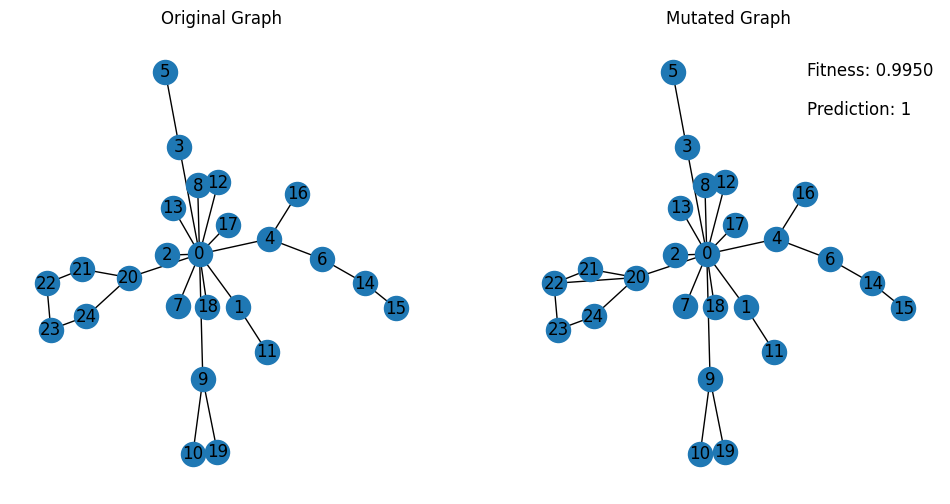

In [286]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

index = random.randint(0, len(final_population) - 1)
print("Fitness:", final_population[index].fitness)
graph_neig = Data(x=final_population[index].x, edge_index=final_population[index].edge_index)

def layout(G):
    return nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Original Graph")
G_original = to_networkx(graphX, to_undirected=True)
pos = layout(G_original)  
nx.draw(G_original, with_labels=True, pos=pos)

plt.subplot(122)
plt.title("Mutated Graph")
plt.text(0.5, 0.5, "Fitness: {:.4f}".format(final_population[index].fitness), fontsize=12)
G_mutated = to_networkx(graph_neig, to_undirected=True)
plt.text(0.5, 0.4,
         "Prediction: {}".format(model.predict(graph_neig.x, ensure_undirected(graph_neig.edge_index), None, 1).argmax(dim=-1).item()), 
         fontsize=12)

nx.draw(G_mutated, with_labels=True, pos=pos)
plt.show()

In [224]:
y_X = model.predict(graphX.x, ensure_undirected(graphX.edge_index), None, 1)
print("y_X:", y_X)
y_G = model.predict(graph_neig.x, ensure_undirected(graph_neig.edge_index), None, 1)
print("y_child:", y_G)
same_class = y_X.argmax() != y_G.argmax()
print("same_class:", same_class)
same_confidence = torch.isclose(y_X.max(), y_G.max(), atol=1e-5)
print("same_confidence:", same_confidence)
similarity = 0.0
if same_class and same_confidence:
    similarity = 1.0
similarity

y_X: tensor([[4.8773e-10, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
y_child: tensor([[1.0000e+00, 2.7312e-08]], grad_fn=<SoftmaxBackward0>)
same_class: tensor(True)
same_confidence: tensor(True)


1.0

In [123]:
import pandas as pd
import torch
import numpy as np
from model.gin import *


df = prepare_dataframe(final_population, model, device, ground_truth=False, only_edge=True)
df.head()

,n0_n0,n0_n1,n0_n2,n0_n3,n0_n4,n0_n5,n0_n6,n0_n7,n0_n8,n0_n9,...,n21_n22,n21_n23,n21_n24,n22_n22,n22_n23,n22_n24,n23_n23,n23_n24,n24_n24,y
0,0,1,1,1,1,0,0,1,1,1,...,1,0,0,0,1,0,0,1,0,0
1,0,1,1,1,1,0,0,1,1,1,...,1,0,0,0,1,0,0,1,0,0
2,0,1,1,1,1,0,0,1,1,1,...,1,0,0,0,1,0,0,1,0,0
3,0,1,1,1,1,0,0,1,1,1,...,1,0,0,0,1,0,0,1,0,0
4,0,1,1,1,1,0,0,1,1,1,...,1,0,0,0,1,0,0,1,0,0


In [124]:
# count number of row has y = 1
class_1 = df[df['y'] == 1].shape[0]
class_0 = df[df['y'] == 0].shape[0]
class_1, class_0


(502, 498)

In [ ]:
df[:5]

,n0_n0,n0_n1,n0_n2,n0_n3,n0_n4,n0_n5,n0_n6,n0_n7,n0_n8,n0_n9,...,n21_n22,n21_n23,n21_n24,n22_n22,n22_n23,n22_n24,n23_n23,n23_n24,n24_n24,y
0,0,1,0,1,1,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
1,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0,1,0,1,1,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
3,0,1,0,1,0,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
4,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.to_pickle("generate_sample.pkl")

In [ ]:
df_loaded = pd.read_pickle("generate_sample.pkl")
df_loaded.shape


(1000, 351)

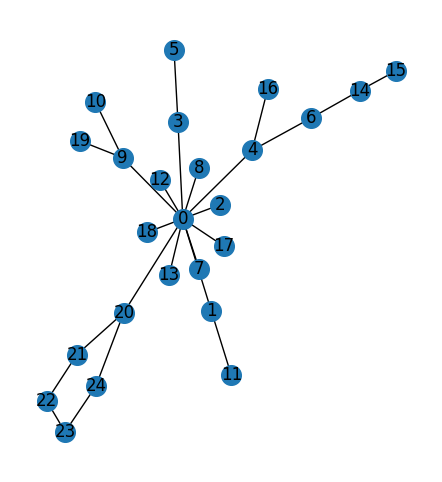

In [ ]:
import pickle
from torch_geometric.utils import to_networkx

def load_graphs_from_pickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

loaded_graphs = dataset[72]
G1 = to_networkx(loaded_graphs, to_undirected=True)
plt.figure(figsize=(12, 6))
plt.subplot(121)
nx.draw(G1, with_labels=True, cmap="coolwarm", node_size=200)


# permuted = load_graphs_from_pickle("graph_permutate.pkl")
# G2 = to_networkx(permuted, to_undirected=True)
# plt.subplot(122)
# nx.draw(G2, with_labels=True, cmap="coolwarm", node_size=200)
# plt.show()

In [ ]:
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
mutag = TUDataset(root="TUDataset", name="MUTAG")

In [ ]:
def pad_matrix(matrix, target_size):
    pad_size = target_size - matrix.shape[0]
    if pad_size > 0:
        pad_matrix = torch.zeros((pad_size, matrix.shape[1]), dtype=matrix.dtype, device=matrix.device)
        matrix = torch.cat([matrix, pad_matrix], dim=0)
        
        pad_matrix = torch.zeros((matrix.shape[0], pad_size), dtype=matrix.dtype, device=matrix.device)
        matrix = torch.cat([matrix, pad_matrix], dim=1)
    return matrix

def pad_features(features, target_size):
    pad_size = target_size - features.shape[0]
    if pad_size > 0:
        pad_matrix = torch.zeros((pad_size, features.shape[1]), dtype=features.dtype, device=features.device)
        features = torch.cat([features, pad_matrix], dim=0)
    return features

def my_distance(data1, data2, adj_weight=0.5, feature_weight=0.5, normalize=True):
    max_nodes = max(data1.num_nodes, data2.num_nodes)

    # Chuyển edge_index thành ma trận kề
    data1.edge_index = ensure_undirected(data1.edge_index)
    data2.edge_index = ensure_undirected(data2.edge_index)
    
    adj1 = torch.zeros((data1.num_nodes, data1.num_nodes), dtype=torch.float32)
    adj1[data1.edge_index[0], data1.edge_index[1]] = 1
    adj1 = pad_matrix(adj1, max_nodes)

    adj2 = torch.zeros((data2.num_nodes, data2.num_nodes), dtype=torch.float32)
    adj2[data2.edge_index[0], data2.edge_index[1]] = 1
    adj2 = pad_matrix(adj2, max_nodes)

    # Tính khoảng cách Frobenius giữa ma trận kề
    adj_distance = torch.norm(adj1 - adj2, p='fro')

    # Padding feature matrix 
    if data1.x is not None and data2.x is not None:
        feature_dim = data1.x.shape[1]  # Giữ nguyên số chiều đặc trưng
        feature1 = pad_features(data1.x, max_nodes)
        feature2 = pad_features(data2.x, max_nodes)
        feature_distance = torch.norm(feature1 - feature2, p='fro')
    else:
        feature_distance = torch.tensor(0.0)

    # Chuẩn hóa khoảng cách về [0,1]
    if normalize:
        max_adj_dist = torch.norm(torch.ones_like(adj1), p='fro')  # Khoảng cách tối đa có thể có
        max_feat_dist = torch.norm(torch.ones_like(feature1), p='fro') if data1.x is not None else 1.0

        adj_distance = adj_distance / max_adj_dist
        feature_distance = feature_distance / max_feat_dist

    total_distance = adj_weight * adj_distance + feature_weight * feature_distance

    return {
        "adj_distance": adj_distance.item(),
        "feature_distance": feature_distance.item(),
        "total_distance": total_distance.item()
    }

In [ ]:
A = dataset[0]
B = dataset[700]
parent1_edges = [tuple(edge.tolist()) for edge in filter_undirected_edges(A.edge_index).T]
parent2_edges = [tuple(edge.tolist()) for edge in filter_undirected_edges(B.edge_index).T]
print(parent1_edges)
print(parent2_edges)
cut = random.randint(1, len(parent1_edges) - 1)
print(cut)
print(parent1_edges[:cut])
print(parent2_edges[cut:])
child_edges = parent1_edges[:cut] + parent2_edges[cut:]
# print(cut1, cut2)
# child_edges = parent1_edges[:cut1] + parent2_edges[cut1:cut2] + parent1_edges[cut2:]
print(child_edges)
child_edges = list(set(child_edges))  
new_edge_index = torch.tensor(child_edges, dtype=torch.long).T


[(0, 1), (0, 3), (0, 4), (0, 7), (0, 13), (0, 14), (0, 16), (0, 18), (0, 20), (1, 2), (1, 5), (1, 9), (2, 10), (4, 12), (4, 17), (5, 6), (5, 8), (6, 11), (13, 15), (15, 19), (20, 21), (20, 24), (21, 22), (22, 23), (23, 24)]
[(0, 1), (0, 4), (0, 17), (0, 20), (1, 2), (1, 3), (1, 5), (1, 9), (1, 13), (1, 19), (3, 7), (3, 14), (4, 6), (5, 8), (5, 15), (5, 16), (6, 10), (6, 11), (6, 12), (8, 18), (20, 21), (20, 23), (20, 24), (21, 22), (21, 24), (22, 23)]
23
[(0, 1), (0, 3), (0, 4), (0, 7), (0, 13), (0, 14), (0, 16), (0, 18), (0, 20), (1, 2), (1, 5), (1, 9), (2, 10), (4, 12), (4, 17), (5, 6), (5, 8), (6, 11), (13, 15), (15, 19), (20, 21), (20, 24), (21, 22)]
[(21, 22), (21, 24), (22, 23)]
[(0, 1), (0, 3), (0, 4), (0, 7), (0, 13), (0, 14), (0, 16), (0, 18), (0, 20), (1, 2), (1, 5), (1, 9), (2, 10), (4, 12), (4, 17), (5, 6), (5, 8), (6, 11), (13, 15), (15, 19), (20, 21), (20, 24), (21, 22), (21, 22), (21, 24), (22, 23)]


In [ ]:
def my_distance2(data1, data2, adj_weight=0.5, feature_weight=0.5):
    data1.edge_index = ensure_undirected(data1.edge_index)
    data2.edge_index = ensure_undirected(data2.edge_index)
    
    edges_1 = set(tuple(edge.tolist()) for edge in data1.edge_index.T)
    edges_2 = set(tuple(edge.tolist()) for edge in data2.edge_index.T)
    
    num_common_edges = len(edges_1.intersection(edges_2))
    num_total_edges = len(edges_1.union(edges_2))
    adj_distance = 1.0 - num_common_edges / num_total_edges
    
    max_nodes = max(data1.x.shape[0], data2.x.shape[0])
    feature_distance = torch.tensor(0.0)
    if data1.x is not None and data2.x is not None:
        feature1 = pad_features(data1.x, max_nodes)
        feature2 = pad_features(data2.x, max_nodes)
        feature_distance = torch.norm(feature1 - feature2, p='fro')
    else:
        feature_distance = torch.tensor(0.0)
    
    feature_distance = feature_distance / torch.norm(torch.ones_like(feature1), p='fro')
    
    total_distance = adj_weight * adj_distance + feature_weight * feature_distance
    return total_distance.item()


In [ ]:
graphA = dataset[0]
print("Graph A:", graphA.edge_index.size())
graphX = dataset[6]
my_distance2(graphA, graphX)

Graph A: torch.Size([2, 50])


0.39024388790130615